In [3]:
import warnings
warnings.filterwarnings('ignore')

# Plotting program
import matplotlib.pyplot as plt

# System
import os
import sys
from glob import glob

# Good for reading/writing data tables
import pandas as pd

# Better math, numbers, and array functions
import numpy as np

# Astropy
from astropy.timeseries import LombScargle
from astropy.io import fits, ascii
from astropy.table import Table, join

# Download TESS
from astroquery.mast import Tesscut
from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
import astropy.units as units

from astroquery.vizier import Vizier # then we import the Vizier() tool
from astroquery.xmatch import XMatch # ...and the Xmatch() tool

# TESS cpm
import tess_cpm as tess_cpm

In [7]:
# download the catalog

vizier_code = 'J/ApJ/904/140/table5'

query_catalog = Vizier()

query_catalog.ROW_LIMIT = -1

curtis_rot = query_catalog.get_catalogs(vizier_code)[0]

curtis_rot

<Table length=923>
  Cluster      Age      Av   ... Simbad  _RA.icrs   _DE.icrs 
               Gyr     mag   ...           deg        deg    
   str12     float32 float32 ...  str6   float64    float64  
------------ ------- ------- ... ------ ---------- ----------
    Pleiades   0.120   0.120 ... Simbad  53.882158  22.823390
    Pleiades   0.120   0.120 ... Simbad  54.046203  23.806264
    Pleiades   0.120   0.120 ... Simbad  54.101510  22.623601
    Pleiades   0.120   0.120 ... Simbad  54.160077  23.145484
    Pleiades   0.120   0.120 ... Simbad  54.485193  23.382239
    Pleiades   0.120   0.120 ... Simbad  54.594179  22.499485
         ...     ...     ... ...    ...        ...        ...
Ruprecht 147   2.700   0.300 ... Simbad 289.266390 -16.135371
Ruprecht 147   2.700   0.300 ... Simbad 289.460250 -16.624023
Ruprecht 147   2.700   0.300 ... Simbad 288.586900 -16.749012
Ruprecht 147   2.700   0.300 ... Simbad 288.978840 -17.770926
Ruprecht 147   2.700   0.300 ... Simbad 288.383960 -16.286807
Ruprecht 147   2.700   0.300 ... Simbad 289.379180 -16.954553

In [58]:

def filter_targets_by_bp_rp(targets, bp_rp_min, bp_rp_max):
    filtered_indices = np.where((targets['BP-RP'] >= bp_rp_min) & (targets['BP-RP'] <= bp_rp_max))[0]
    return targets[filtered_indices]

def query_tess_observations(target):
    target_coord = SkyCoord(target['RA_ICRS'], target['DE_ICRS'], unit=(units.deg, units.deg))
    obs_table = Observations.query_criteria(coordinates=target_coord, radius=5*units.arcsec, obs_collection="TESS")
    return obs_table

def download_and_plot_lightcurves(obs_table, target, cluster_name, bp_rp_min, bp_rp_max):
    lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries")

# Define the BP-RP ranges
bp_rp_ranges = [(0.6, 1.0)]

# Filter the targets within each BP-RP range and query TESS observations
praesepe_index = np.where(curtis_rot['Cluster'] == 'Praesepe')[0]
praesepe_targets = curtis_rot[praesepe_index]

for bp_rp_min, bp_rp_max in bp_rp_ranges:
    filtered_targets = filter_targets_by_bp_rp(praesepe_targets, bp_rp_min, bp_rp_max)
    selected_targets = filtered_targets[:3]  # Select first 3 targets for simplicity
    print(f"Number of targets in Praesepe cluster between {bp_rp_min} and {bp_rp_max} BP-RP: {len(selected_targets)}")
    
    for target in selected_targets:
        obs_table = query_tess_observations(target)
        download_and_plot_lightcurves(obs_table, target, 'Praesepe', bp_rp_min, bp_rp_max)

query_tess_observations(target)

Number of targets in Praesepe cluster between 0.6 and 1.0 BP-RP: 3


<Table masked=True length=9>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 143466235 143466235      0.0
   science           TESS            SPOC ... 363392046 363392046      0.0
   science           TESS            SPOC ... 132345134 132345134      0.0
   science           TESS            SPOC ... 133655699 133655699      0.0
   science           TESS            SPOC ... 137206440 137206440      0.0
   science           TESS            SPOC ... 137684104 137684104      0.0
   science           TESS            SPOC ... 142803481 142803481      0.0
   science           TESS            SPOC ... 362243443 362243443      0.0
   science           TESS            SPOC ... 362243448 362243448      0.0

In [70]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries")


lightcurves

<Table masked=True length=7>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 132345024 132345024      0.0
   science           TESS            SPOC ... 137206320 137206320      0.0
   science           TESS            SPOC ... 144516065 144516065      0.0
   science           TESS            SPOC ... 144516090 144516090      0.0
   science           TESS            SPOC ... 383500172 383500172      0.0
   science           TESS            SPOC ... 383500186 383500186      0.0
   science           TESS            SPOC ... 383500197 383500197      0.0

In [74]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[44])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [76]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576576-Sector_0044.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576576-Sector_0044.fits

In [78]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [80]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576576-Sector_0044.fits')[1]

target_lc.data

FITS_rec([(2500.1809861 , -0.00173335, 916364,       nan,       nan,      nan,       nan,      nan,       nan, 168, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          (2500.18237512, -0.00173321, 916365,       nan,       nan,      nan,       nan,      nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          (2500.18376414, -0.00173308, 916366,       nan,       nan,      nan,       nan,      nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          ...,
          (2524.4375439 ,  0.00066849, 933827, 441.17624, 3.9628842, 593.4522, 1.4238945, 697.8107, 6.3387194,   0, nan, nan, nan, nan, 221.74739928, 0.00396903, 1843.738911  , 0.00399609, 0.01217365, -0.09532892),
          (2524.43893292,  0.00066862, 933828, 439.53833, 3.962265 , 595.1995, 1.4253904, 694.6748, 6.337729 ,   0, nan, nan,

In [82]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                17466 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [84]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

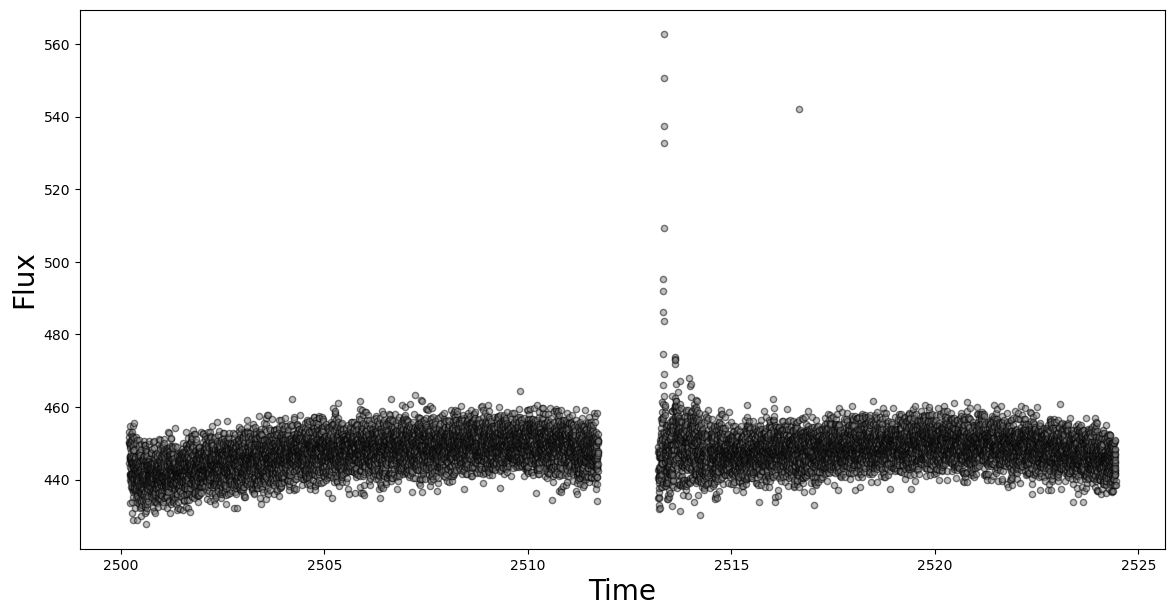

In [86]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [106]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[45])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [108]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576576-Sector_0045.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576576-Sector_0045.fits

In [110]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [114]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576576-Sector_0045.fits')[1]

target_lc.data

FITS_rec([(2525.50289159, 0.00073363, 934594,       nan,       nan,       nan,       nan,       nan,       nan, 16552, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          (2525.50428062, 0.00073376, 934595,       nan,       nan,       nan,       nan,       nan,       nan, 16416, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          (2525.50566964, 0.0007339 , 934596,       nan,       nan,       nan,       nan,       nan,       nan, 16416, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          ...,
          (2550.62468077, 0.00308954, 952680, 1252.6117, 6.3109384, 1145.4524, 2.7875786, 1646.7196, 8.9479475,     0, nan, nan, nan, nan, 93.7725556 , 0.00341823, 26.75153661, 0.00341667, -4.9443541e-05, -0.02227005),
          (2550.62606977, 0.00308965, 952681, 1257.7994, 6.310889 , 1146.3157, 2.7883246, 1654.6158, 8.947878

In [116]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18089 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [118]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

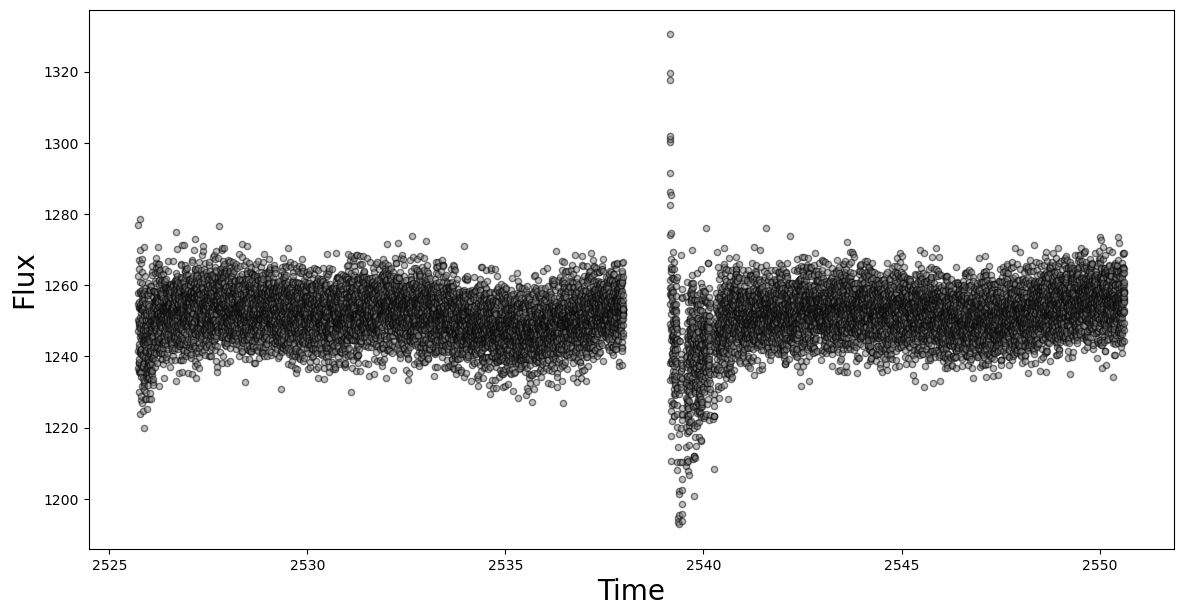

In [120]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [122]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[46])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [124]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576576-Sector_0046.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576576-Sector_0046.fits

In [126]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [128]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576576-Sector_0046.fits')[1]

target_lc.data

FITS_rec([(2551.56362412, 0.00316187, 953356,       nan,       nan,       nan,       nan,       nan,      nan, 16552, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          (2551.56501311, 0.00316198, 953357,       nan,       nan,       nan,       nan,       nan,      nan, 16544, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          (2551.56640211, 0.00316209, 953358,       nan,       nan,       nan,       nan,       nan,      nan, 16544, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          ...,
          (2578.7029523 , 0.00500223, 972895, 1110.7971, 4.8736305, 579.2329 , 1.5292784, 1759.7126, 7.931345,     0, nan, nan, nan, nan, 109.45848749, 0.00210967, 734.48817713, 0.00211108, 0.00364306, 0.02861683),
          (2578.70434125, 0.00500229, 972896, 1103.1869, 4.8710256, 581.70605, 1.5304849, 1747.3309, 7.927106,     0, nan, na

In [130]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                19542 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [132]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

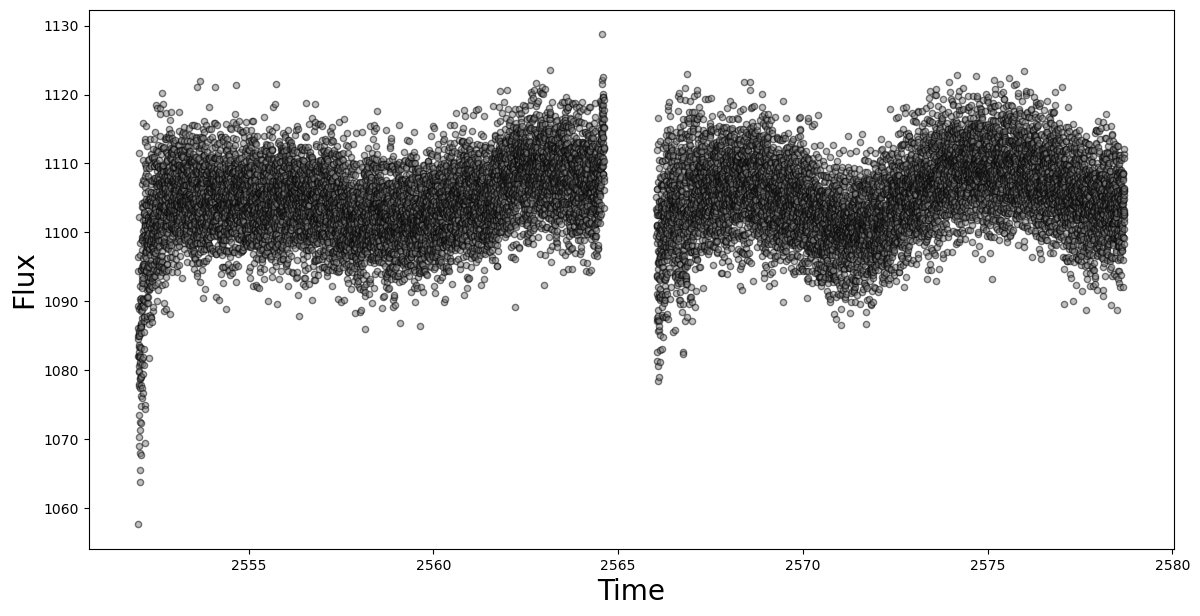

In [134]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [136]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[72])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [138]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576576-Sector_0072.fits']

lightcurves

<Table masked=True length=2>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576576-Sector_0072.fits
   science ... TESS_Mission_LCc661251966599576576-Sector_0072.fits

In [140]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [144]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/tess2023315124025-s0072-0000000175265714-0267-a_fast/TESS_Mission_LCc661251966599576576-Sector_0072.fits')[1]

target_lc.data

FITS_rec([(3260.17874952, 0.00111558, 8781366,       nan,       nan,      nan,       nan,       nan,       nan, 168, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.17898102, 0.0011156 , 8781367,       nan,       nan,      nan,       nan,       nan,       nan, 160, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.17921253, 0.00111562, 8781368,       nan,       nan,      nan,       nan,       nan,       nan, 160, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          ...,
          (3285.58683389, 0.00342449, 8891119, 1159.8275, 12.437949, 890.1545, 4.7492976, 1698.6937, 19.079844,   0, nan, nan, nan, nan, 331.75193268, 0.00643113, 711.26900358, 0.00644849, 0.01215871, -0.02998364),
          (3285.58706539, 0.00342451, 8891120, 1172.821 , 12.459336, 895.7497, 4.7538476, 1718.3217, 19.11265 ,   0, nan, nan

In [146]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =               109756 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days&' / column units: Barycenter corrected TESS Julia
CONTINUE  '' /n Date (BTJD)                                                     
TDISP1  = 'D14.7   '        

In [148]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

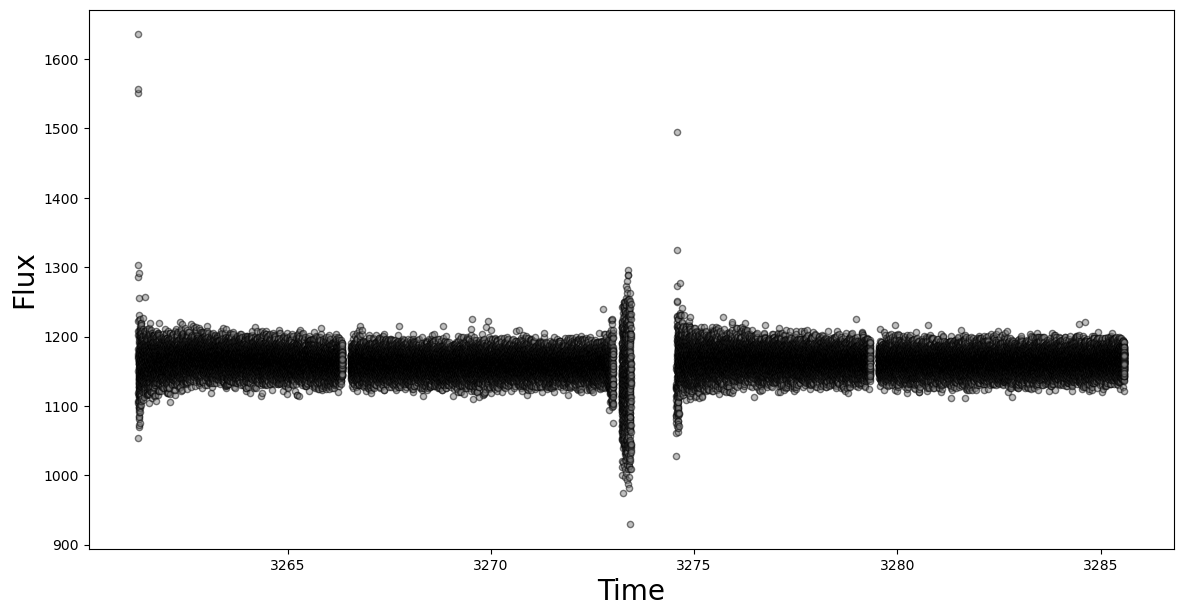

In [150]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [88]:
# Define the BP-RP ranges
bp_rp_ranges_b = [(1.0, 1.5)]

# Filter the targets within each BP-RP range and query TESS observations
praesepe_index_b = np.where(curtis_rot['Cluster'] == 'Praesepe')[0]
praesepe_targets_b = curtis_rot[praesepe_index_b]

for bp_rp_min, bp_rp_max in bp_rp_ranges_b:
    filtered_targets_b = filter_targets_by_bp_rp(praesepe_targets, bp_rp_min, bp_rp_max)
    selected_targets_b = filtered_targets_b[:3]  # Select first 3 targets for simplicity
    print(f"Number of targets in Praesepe cluster between {bp_rp_min} and {bp_rp_max} BP-RP: {len(selected_targets)}")
    
    for target in selected_targets_b:
        obs_table = query_tess_observations(target)
        download_and_plot_lightcurves(obs_table, target, 'Praesepe', bp_rp_min, bp_rp_max)

query_tess_observations(target)

Number of targets in Praesepe cluster between 1.0 and 1.5 BP-RP: 3


<Table masked=True length=9>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 132345114 132345114      0.0
   science           TESS            SPOC ... 133655699 133655699      0.0
   science           TESS            SPOC ... 137206407 137206407      0.0
   science           TESS            SPOC ... 137684104 137684104      0.0
   science           TESS            SPOC ... 142803449 142803449      0.0
   science           TESS            SPOC ... 143466235 143466235      0.0
   science           TESS            SPOC ... 362243423 362243423      0.0
   science           TESS            SPOC ... 362243431 362243431      0.0
   science           TESS            SPOC ... 363392046 363392046      0.0

In [90]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries")


lightcurves

<Table masked=True length=5>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 132345114 132345114      0.0
   science           TESS            SPOC ... 137206407 137206407      0.0
   science           TESS            SPOC ... 142803449 142803449      0.0
   science           TESS            SPOC ... 362243423 362243423      0.0
   science           TESS            SPOC ... 362243431 362243431      0.0

In [92]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[44])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [94]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576577-Sector_0044.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576577-Sector_0044.fits

In [96]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [98]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576577-Sector_0044.fits')[1]

target_lc.data

FITS_rec([(2500.18095317, -0.00176627, 916364,       nan,       nan,      nan,       nan,       nan,       nan, 168, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          (2500.18234219, -0.00176614, 916365,       nan,       nan,      nan,       nan,       nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          (2500.18373121, -0.00176601, 916366,       nan,       nan,      nan,       nan,       nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          ...,
          (2524.43751046,  0.00063505, 933827, 1217.2203, 5.293478 , 801.535 , 1.7148843, 1735.3116, 7.408293 ,   0, nan, nan, nan, nan, 113.62063363, 0.00208743, 1785.2086467 , 0.00206976, 0.00935638, -0.09734052),
          (2524.43889948,  0.00063518, 933828, 1216.2983, 5.2925835, 802.3191, 1.7153903, 1733.1886, 7.4070406,   0, nan,

In [100]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                17466 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [102]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

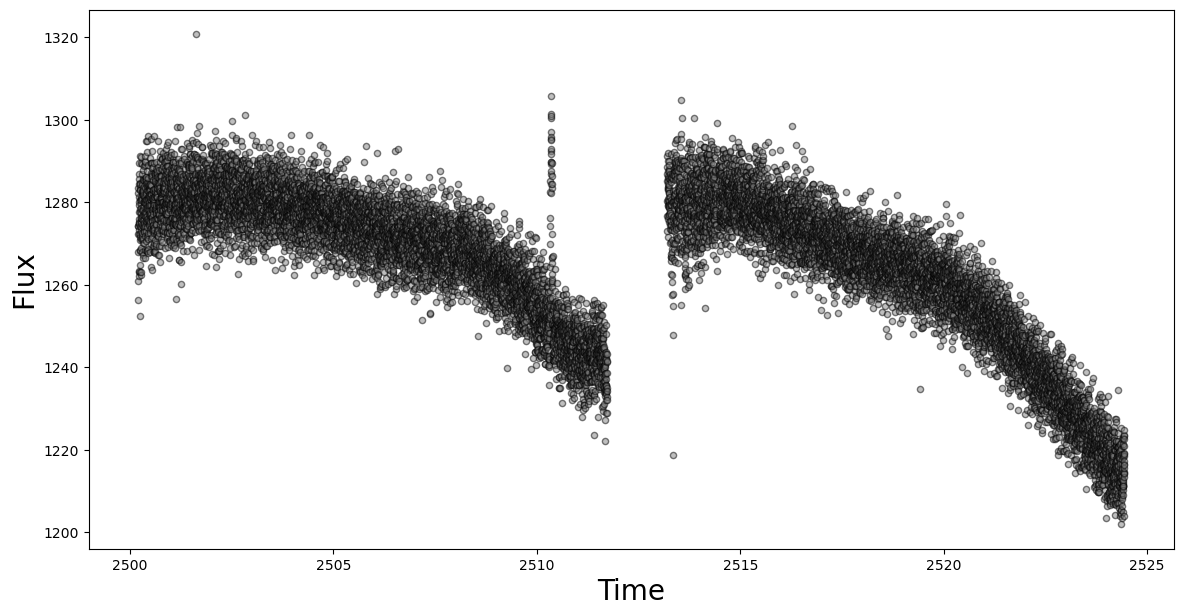

In [104]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [152]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[45])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [154]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576577-Sector_0045.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576577-Sector_0045.fits

In [156]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [158]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576577-Sector_0045.fits')[1]

target_lc.data

FITS_rec([(2525.50289159, 0.00073363, 934594,       nan,       nan,       nan,       nan,       nan,       nan, 16552, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          (2525.50428062, 0.00073376, 934595,       nan,       nan,       nan,       nan,       nan,       nan, 16416, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          (2525.50566964, 0.0007339 , 934596,       nan,       nan,       nan,       nan,       nan,       nan, 16416, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          ...,
          (2550.62468077, 0.00308954, 952680, 1252.6117, 6.3109384, 1145.4524, 2.7875786, 1646.7196, 8.9479475,     0, nan, nan, nan, nan, 93.7725556 , 0.00341823, 26.75153661, 0.00341667, -4.9443541e-05, -0.02227005),
          (2550.62606977, 0.00308965, 952681, 1257.7994, 6.310889 , 1146.3157, 2.7883246, 1654.6158, 8.947878

In [160]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18089 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [162]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

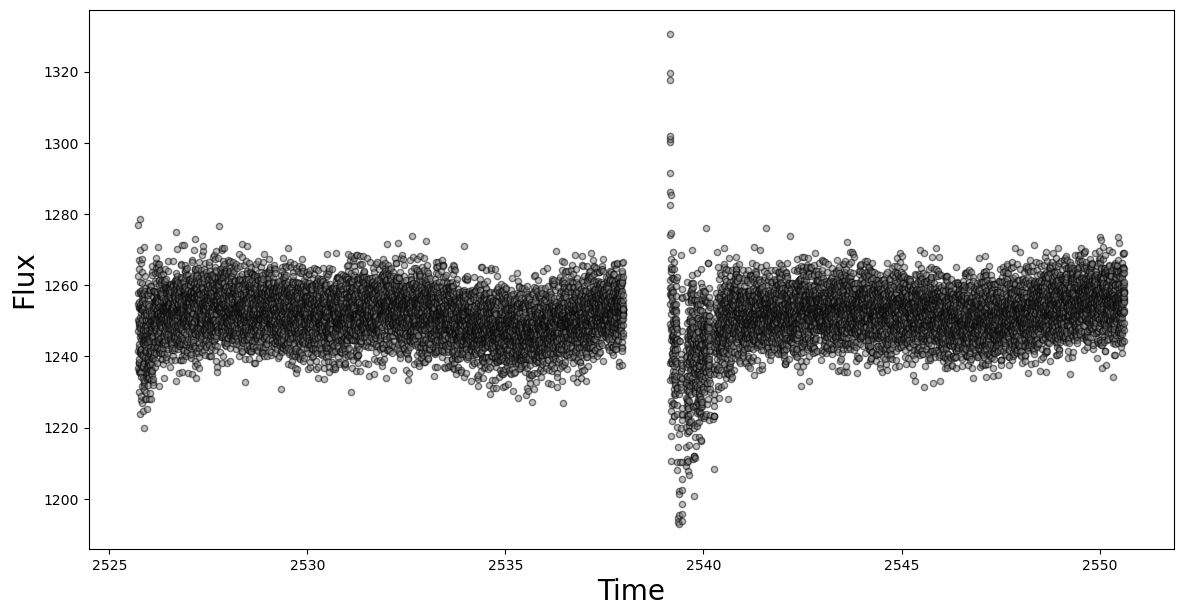

In [164]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [166]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[46])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [168]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576577-Sector_0046.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576577-Sector_0046.fits

In [170]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [172]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576577-Sector_0046.fits')[1]

target_lc.data

FITS_rec([(2551.56362412, 0.00316187, 953356,       nan,       nan,       nan,       nan,       nan,      nan, 16552, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          (2551.56501311, 0.00316198, 953357,       nan,       nan,       nan,       nan,       nan,      nan, 16544, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          (2551.56640211, 0.00316209, 953358,       nan,       nan,       nan,       nan,       nan,      nan, 16544, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          ...,
          (2578.7029523 , 0.00500223, 972895, 1110.7971, 4.8736305, 579.2329 , 1.5292784, 1759.7126, 7.931345,     0, nan, nan, nan, nan, 109.45848749, 0.00210967, 734.48817713, 0.00211108, 0.00364306, 0.02861683),
          (2578.70434125, 0.00500229, 972896, 1103.1869, 4.8710256, 581.70605, 1.5304849, 1747.3309, 7.927106,     0, nan, na

In [174]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                19542 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [176]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

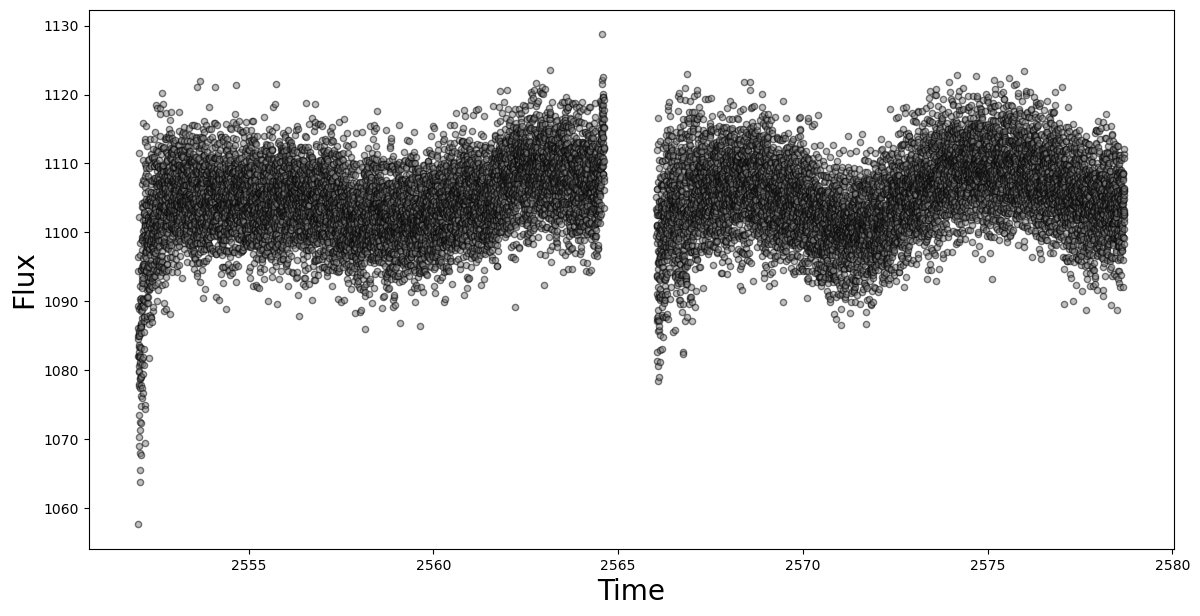

In [178]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [180]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[72])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [182]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576577-Sector_0072.fits']

lightcurves

<Table masked=True length=2>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576577-Sector_0072.fits
   science ... TESS_Mission_LCc661251966599576577-Sector_0072.fits

In [184]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [186]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/tess2023315124025-s0072-0000000175265714-0267-s/TESS_Mission_LCc661251966599576577-Sector_0072.fits')[1]

target_lc.data

FITS_rec([(3260.17932828, 0.00111563, 1463561,       nan,       nan,       nan,       nan,       nan,      nan, 168, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.1807173 , 0.00111576, 1463562,       nan,       nan,       nan,       nan,       nan,      nan, 160, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.18210631, 0.00111589, 1463563,       nan,       nan,       nan,       nan,       nan,      nan,  32, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          ...,
          (3285.58301417, 0.00342421, 1481850, 1162.7656, 5.5953574, 889.7864 , 2.1168206, 1713.5547, 8.583291,   0, nan, nan, nan, nan, 331.76279245, 0.00288305, 711.26723935, 0.00290235, 0.01191787, -0.00530873),
          (3285.58440316, 0.00342431, 1481851, 1164.6812, 5.6001678, 889.88525, 2.1154034, 1717.9608, 8.59067 ,   0, nan, nan

In [188]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18292 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days&' / column units: Barycenter corrected TESS Julia
CONTINUE  '' /n Date (BTJD)                                                     
TDISP1  = 'D14.7   '        

In [190]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

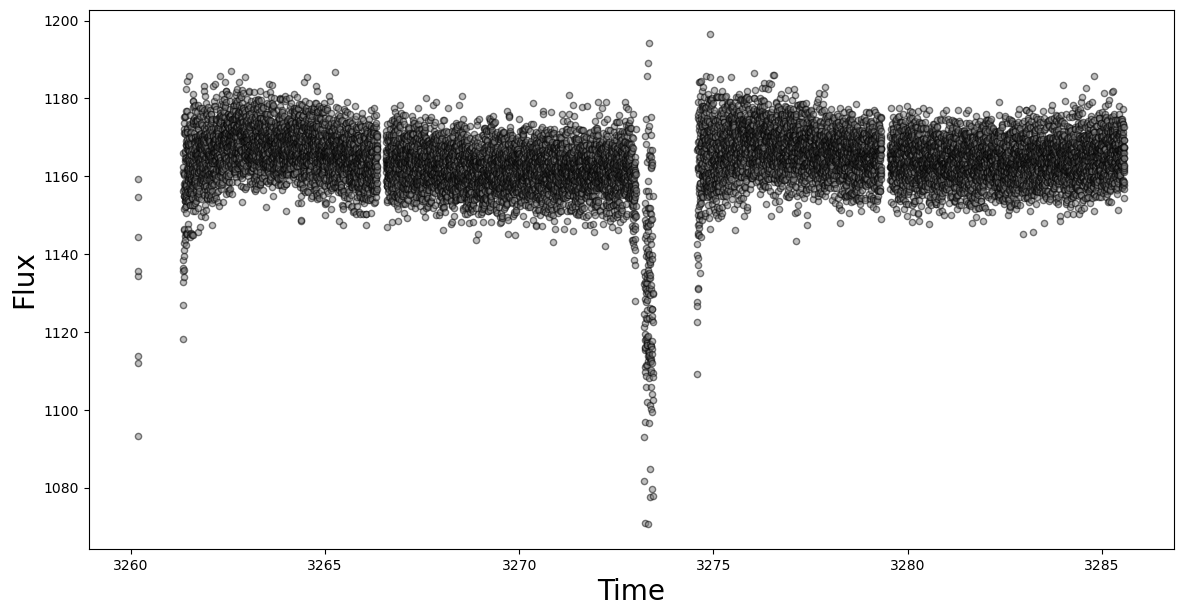

In [192]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [68]:
# Define the BP-RP ranges
bp_rp_ranges_c = [(1.5, 2.0)]

# Filter the targets within each BP-RP range and query TESS observations
praesepe_index_c = np.where(curtis_rot['Cluster'] == 'Praesepe')[0]
praesepe_targets_c = curtis_rot[praesepe_index_c]

for bp_rp_min, bp_rp_max in bp_rp_ranges_c:
    filtered_targets_c = filter_targets_by_bp_rp(praesepe_targets, bp_rp_min, bp_rp_max)
    selected_targets_c = filtered_targets_c[:3]  # Select first 3 targets for simplicity
    print(f"Number of targets in Praesepe cluster between {bp_rp_min} and {bp_rp_max} BP-RP: {len(selected_targets)}")
    
    for target in selected_targets_c:
        obs_table = query_tess_observations(target)
        download_and_plot_lightcurves(obs_table, target, 'Praesepe', bp_rp_min, bp_rp_max)

query_tess_observations(target)

Number of targets in Praesepe cluster between 1.5 and 2.0 BP-RP: 3


<Table masked=True length=11>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 132345024 132345024      0.0
   science           TESS            SPOC ... 133655699 133655699      0.0
   science           TESS            SPOC ... 137206320 137206320      0.0
   science           TESS            SPOC ... 137684104 137684104      0.0
   science           TESS            SPOC ... 143466235 143466235      0.0
   science           TESS            SPOC ... 144516065 144516065      0.0
   science           TESS            SPOC ... 144516090 144516090      0.0
   science           TESS            SPOC ... 363392046 363392046      0.0
   science           TESS            SPOC ... 383500172 383500172      0.0
   science           TESS            SPOC ... 383500186 383500186      0.0
   science           TESS            SPOC ... 383500197 383500197      0.0

In [194]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries")


lightcurves

<Table masked=True length=5>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 132345114 132345114      0.0
   science           TESS            SPOC ... 137206407 137206407      0.0
   science           TESS            SPOC ... 142803449 142803449      0.0
   science           TESS            SPOC ... 362243423 362243423      0.0
   science           TESS            SPOC ... 362243431 362243431      0.0

In [196]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[44])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [198]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576578-Sector_0044.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576578-Sector_0044.fits

In [200]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [202]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576578-Sector_0044.fits')[1]

target_lc.data

FITS_rec([(2500.18095317, -0.00176627, 916364,       nan,       nan,      nan,       nan,       nan,       nan, 168, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          (2500.18234219, -0.00176614, 916365,       nan,       nan,      nan,       nan,       nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          (2500.18373121, -0.00176601, 916366,       nan,       nan,      nan,       nan,       nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,         nan),
          ...,
          (2524.43751046,  0.00063505, 933827, 1217.2203, 5.293478 , 801.535 , 1.7148843, 1735.3116, 7.408293 ,   0, nan, nan, nan, nan, 113.62063363, 0.00208743, 1785.2086467 , 0.00206976, 0.00935638, -0.09734052),
          (2524.43889948,  0.00063518, 933828, 1216.2983, 5.2925835, 802.3191, 1.7153903, 1733.1886, 7.4070406,   0, nan,

In [204]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                17466 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [206]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

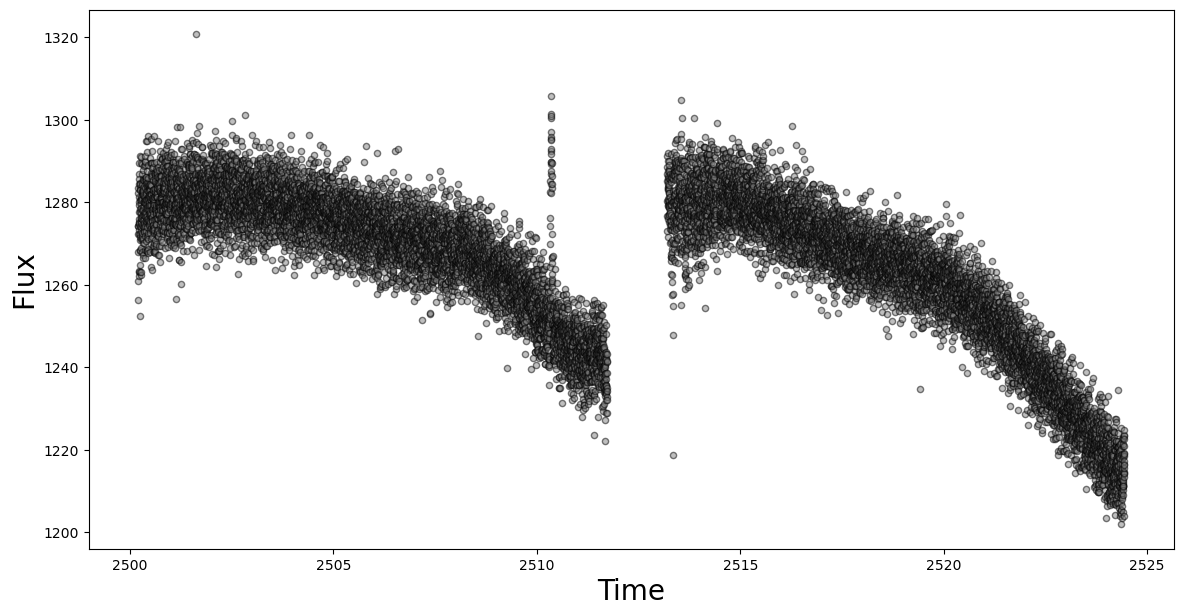

In [208]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [212]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[45])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [214]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576578-Sector_0045.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576578-Sector_0045.fits

In [216]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [218]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576578-Sector_0045.fits')[1]

target_lc.data

FITS_rec([(2525.50289159, 0.00073363, 934594,       nan,       nan,       nan,       nan,       nan,       nan, 16552, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          (2525.50428062, 0.00073376, 934595,       nan,       nan,       nan,       nan,       nan,       nan, 16416, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          (2525.50566964, 0.0007339 , 934596,       nan,       nan,       nan,       nan,       nan,       nan, 16416, nan, nan, nan, nan,         nan,        nan,         nan,        nan,            nan,         nan),
          ...,
          (2550.62468077, 0.00308954, 952680, 1252.6117, 6.3109384, 1145.4524, 2.7875786, 1646.7196, 8.9479475,     0, nan, nan, nan, nan, 93.7725556 , 0.00341823, 26.75153661, 0.00341667, -4.9443541e-05, -0.02227005),
          (2550.62606977, 0.00308965, 952681, 1257.7994, 6.310889 , 1146.3157, 2.7883246, 1654.6158, 8.947878

In [220]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18089 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [222]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

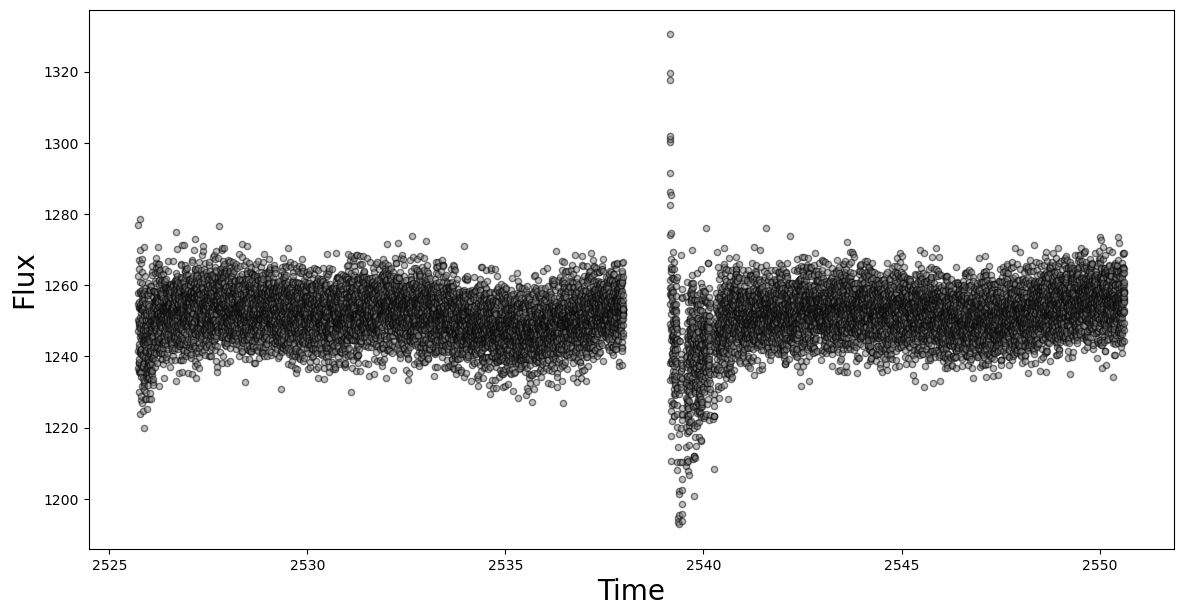

In [224]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [226]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[46])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [228]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576578-Sector_0046.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576578-Sector_0046.fits

In [230]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [232]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LCc661251966599576578-Sector_0046.fits')[1]

target_lc.data

FITS_rec([(2551.56362412, 0.00316187, 953356,       nan,       nan,       nan,       nan,       nan,      nan, 16552, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          (2551.56501311, 0.00316198, 953357,       nan,       nan,       nan,       nan,       nan,      nan, 16544, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          (2551.56640211, 0.00316209, 953358,       nan,       nan,       nan,       nan,       nan,      nan, 16544, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,        nan),
          ...,
          (2578.7029523 , 0.00500223, 972895, 1110.7971, 4.8736305, 579.2329 , 1.5292784, 1759.7126, 7.931345,     0, nan, nan, nan, nan, 109.45848749, 0.00210967, 734.48817713, 0.00211108, 0.00364306, 0.02861683),
          (2578.70434125, 0.00500229, 972896, 1103.1869, 4.8710256, 581.70605, 1.5304849, 1747.3309, 7.927106,     0, nan, na

In [234]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                19542 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [236]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

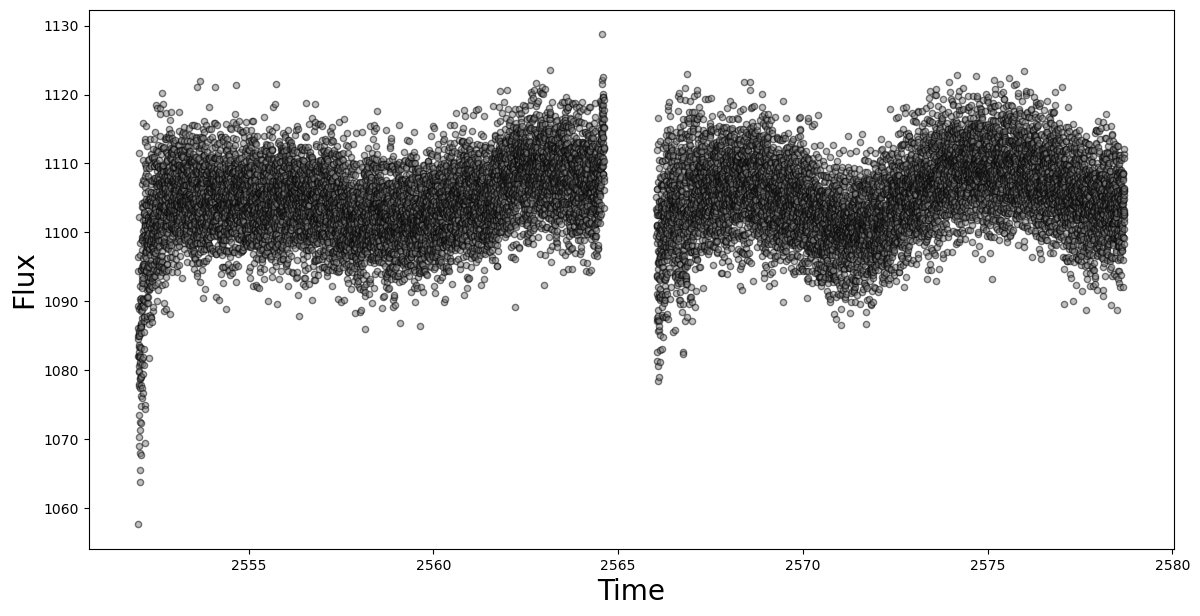

In [238]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [240]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[72])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [242]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576578-Sector_0072.fits']

lightcurves

<Table masked=True length=2>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LCc661251966599576578-Sector_0072.fits
   science ... TESS_Mission_LCc661251966599576578-Sector_0072.fits

In [244]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [246]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/tess2023315124025-s0072-0000000175265714-0267-a_fast/TESS_Mission_LCc661251966599576578-Sector_0072.fits')[1]

target_lc.data

FITS_rec([(3260.17874952, 0.00111558, 8781366,       nan,       nan,      nan,       nan,       nan,       nan, 168, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.17898102, 0.0011156 , 8781367,       nan,       nan,      nan,       nan,       nan,       nan, 160, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.17921253, 0.00111562, 8781368,       nan,       nan,      nan,       nan,       nan,       nan, 160, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          ...,
          (3285.58683389, 0.00342449, 8891119, 1159.8275, 12.437949, 890.1545, 4.7492976, 1698.6937, 19.079844,   0, nan, nan, nan, nan, 331.75193268, 0.00643113, 711.26900358, 0.00644849, 0.01215871, -0.02998364),
          (3285.58706539, 0.00342451, 8891120, 1172.821 , 12.459336, 895.7497, 4.7538476, 1718.3217, 19.11265 ,   0, nan, nan

In [248]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =               109756 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days&' / column units: Barycenter corrected TESS Julia
CONTINUE  '' /n Date (BTJD)                                                     
TDISP1  = 'D14.7   '        

In [250]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

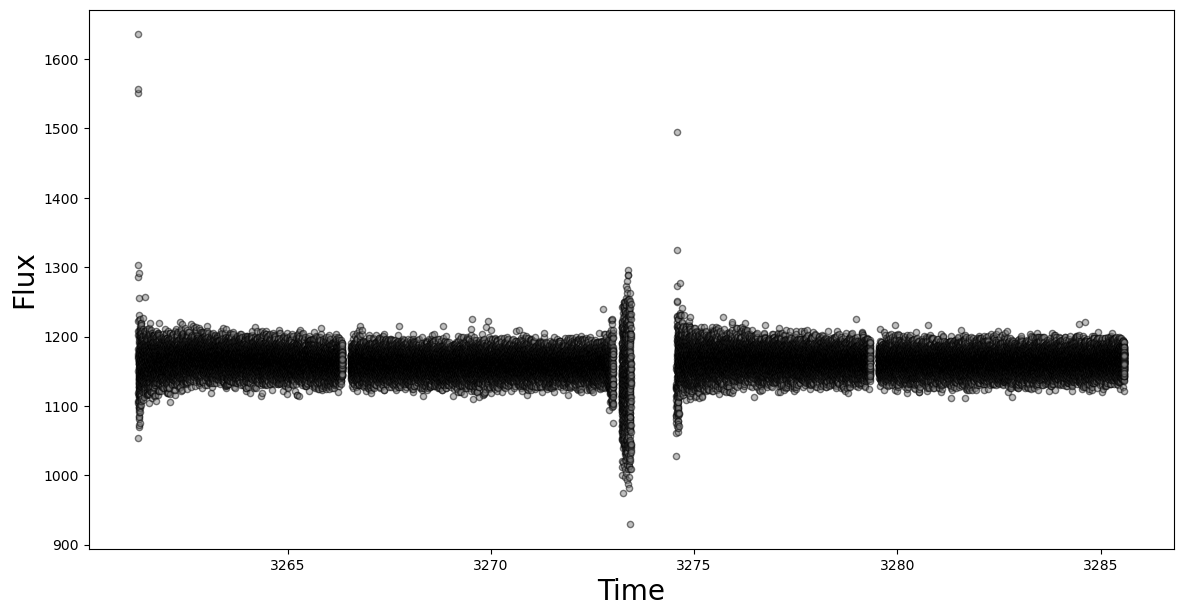

In [252]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [254]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/tess2023315124025-s0072-0000000175265714-0267-s/TESS_Mission_LCc661251966599576578-Sector_0072.fits')[1]

target_lc.data

FITS_rec([(3260.17932828, 0.00111563, 1463561,       nan,       nan,       nan,       nan,       nan,      nan, 168, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.1807173 , 0.00111576, 1463562,       nan,       nan,       nan,       nan,       nan,      nan, 160, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          (3260.18210631, 0.00111589, 1463563,       nan,       nan,       nan,       nan,       nan,      nan,  32, nan, nan, nan, nan,          nan,        nan,          nan,        nan,        nan,         nan),
          ...,
          (3285.58301417, 0.00342421, 1481850, 1162.7656, 5.5953574, 889.7864 , 2.1168206, 1713.5547, 8.583291,   0, nan, nan, nan, nan, 331.76279245, 0.00288305, 711.26723935, 0.00290235, 0.01191787, -0.00530873),
          (3285.58440316, 0.00342431, 1481851, 1164.6812, 5.6001678, 889.88525, 2.1154034, 1717.9608, 8.59067 ,   0, nan, nan

In [256]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18292 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days&' / column units: Barycenter corrected TESS Julia
CONTINUE  '' /n Date (BTJD)                                                     
TDISP1  = 'D14.7   '        

In [258]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

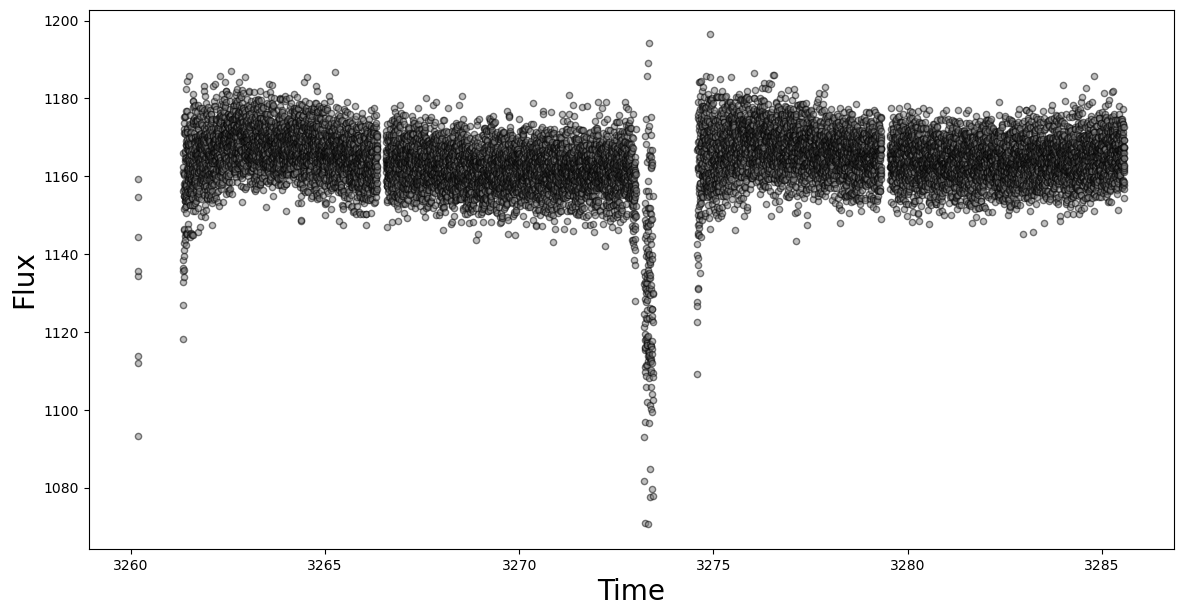

In [260]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()